# Exploratory Modelling

Basic modelling to investigate how variables interact with each other and look for further patterns.

In [104]:
# Load Required Packages
library(plotly)
library(data.table)
library(ggplot2)
library(reshape2)
library(rattle)
library(GGally)
library(rCharts)
library(MASS)
library(lme4)
library(rpart)
library(gridExtra)

# Session Options
options(repr.plot.width=10, repr.plot.height=7)

In [2]:
# Source Data
dt <- fread('/Users/yassineltahir/Downloads/analysisProblemForInterview.csv', 
            colClasses=list(character=1:7))

# Clean & format data
dt$Customer_ID <- as.factor(dt$Customer_ID)
dt$result_rank <- as.numeric(dt$result_rank)
dt$provider_Nm <- as.factor(dt$provider_Nm)
dt$product_name <- as.factor(dt$product_name)
dt$dummy_quote_value <- as.numeric(ifelse(dt$dummy_quote_value == 'MISSING', NA, dt$dummy_quote_value))
dt$Sale_made <- as.factor(dt$Sale_made)
dt$Sale_source <- as.factor(dt$Sale_source)
dt[Sale_source==""]$Sale_source <- "No Sale"

In [25]:
# Binarise Sale_source
for(i in unique(dt$Sale_source)){
    nm <- gsub(" ","_",i)
    dt[,paste0('Sale_souce_',nm):=ifelse(dt$Sale_source == i, 1, 0)]
}

# Binarise provider_Nm
for(i in unique(dt$provider_Nm)){
    nm <- gsub(" ","_",i)
    dt[,paste0('provider_Nm_',nm):=ifelse(dt$provider_Nm == i, 1, 0)]
}

names(dt)

[1] "Customer_ID"            "result_rank"            "provider_Nm"           
 [4] "product_name"           "dummy_quote_value"      "Sale_made"             
 [7] "Sale_source"            "Sale_souce_No Sale"     "Sale_souce_online"     
[10] "Sale_souce_callcentre"  "provider_Nm_Provider A" "provider_Nm_Provider B"
[13] "provider_Nm_Provider_A" "provider_Nm_Provider_B" "Sale_souce_No_Sale"

# Linear Model

Linear models to test variables impact against the following dependent variables:  
1. Sale_made
2. Sale_source
3. Sale_source (where sale occurred)

In [39]:
# Sale Made
glm.sale_made <- glm(Sale_made ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + provider_Nm_Provider_B,
                    data = dt,
                    family=binomial(link='logit'))

summary(glm.sale_made)

# mixed model against customers
glm.sale_made.mixed <- glmer(Sale_made ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + 
                            provider_Nm_Provider_B + (1|Customer_ID),
                            data = dt,
                            family = binomial)
summary(glm.sale_made.mixed)


Call:
glm(formula = Sale_made ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + 
    provider_Nm_Provider_B, family = binomial(link = "logit"), 
    data = dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8303  -0.3720  -0.2698  -0.1903   3.2323  

Coefficients: (1 not defined because of singularities)
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.878e+00  1.938e-01  -9.690  < 2e-16 ***
result_rank            -3.389e-01  3.420e-02  -9.909  < 2e-16 ***
dummy_quote_value       5.764e-04  9.312e-05   6.191 5.99e-10 ***
provider_Nm_Provider_A -1.297e-01  1.671e-01  -0.776    0.438    
provider_Nm_Provider_B         NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1845.2  on 4668  degrees of freedom
Residual deviance: 1709.5  on 4665  degrees of freedom
  (18 observations deleted

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0397548 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Sale_made ~ result_rank + dummy_quote_value + provider_Nm_Provider_A +  
    provider_Nm_Provider_B + (1 | Customer_ID)
   Data: dt

     AIC      BIC   logLik deviance df.resid 
  1717.7   1750.0   -853.9   1707.7     4664 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1217 -0.2497 -0.1782 -0.1247 13.4449 

Random effects:
 Groups      Name        Variance Std.Dev.
 Customer_ID (Intercept) 0.3183   0.5642  
Number of obs: 4669, groups:  Customer_ID, 628

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -2.014e+00  2.206e-01  -9.131  < 2e-16 ***
result_rank            -3.433e-01  3.479e-02  -9.867  < 2e-16 ***
dummy_quote_value       5.991e-04  9.931e-05   6.032 1.61e-09 ***
provider_Nm_Provider_A -1.241e-01  1.712e-01  -0.725    0.468    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 

### Linear Model
- Provider appears insignificant in terms of sale likelihood
- quote value is mildly positively related to sale likelihood. Seems odd that higher price work mean more likely to sell.
- result_rank is negatively related to sale likelihood. Confirms previously seen results that has rank increases fewer sales are made

### Mixed Linear Model
- Pretty poor model so can't be entirely relied upon.
- Same effects seen in terms of result_rank and dummy_quote_value and how they impact sale likelihood.
- Variance explained by customer is quite small.


In [40]:
# Sale Made
glm.sale_source <- glm(Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + provider_Nm_Provider_B,
                    data = dt,
                    family=binomial(link='logit'))

summary(glm.sale_source)

# mixed model against customers
glm.sale_source.mixed <- glmer(Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + 
                            provider_Nm_Provider_B + (1|Customer_ID),
                            data = dt,
                            family = binomial)
summary(glm.sale_source.mixed)


Call:
glm(formula = Sale_source ~ result_rank + dummy_quote_value + 
    provider_Nm_Provider_A + provider_Nm_Provider_B, family = binomial(link = "logit"), 
    data = dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3454   0.1505   0.2021   0.2497   1.8034  

Coefficients: (1 not defined because of singularities)
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.9662854  0.3355680  11.820  < 2e-16 ***
result_rank             0.1978055  0.0447493   4.420 9.86e-06 ***
dummy_quote_value      -0.0006883  0.0000964  -7.140 9.36e-13 ***
provider_Nm_Provider_A -0.8106446  0.2966496  -2.733  0.00628 ** 
provider_Nm_Provider_B         NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1056.86  on 4668  degrees of freedom
Residual deviance:  993.35  on 4665  degrees of freedom
  (18 observations del

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0227659 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A +  
    provider_Nm_Provider_B + (1 | Customer_ID)
   Data: dt

     AIC      BIC   logLik deviance df.resid 
   985.2   1017.5   -487.6    975.2     4664 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.9512   0.0691   0.0934   0.1195   1.1260 

Random effects:
 Groups      Name        Variance Std.Dev.
 Customer_ID (Intercept) 2.013    1.419   
Number of obs: 4669, groups:  Customer_ID, 628

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             4.8719338  0.4411094  11.045  < 2e-16 ***
result_rank             0.2054623  0.0480154   4.279 1.88e-05 ***
dummy_quote_value      -0.0008030  0.0001222  -6.569 5.06e-11 ***
provider_Nm_Provider_A -0.8686933  0.3128954  -2.776   0.0055 ** 
---
Signif. codes:  0 ‘***’ 0.00

### Linear Model
- Almost opposite results to model against Sale_made.
- Higher rank = (slightly) higher sale likelihood
- Lower quote = higher sale likelihood.
- Again coefficient magnitudes are quite small.

### Mixed Linear Model
- Again, pretty poor model so can't be entirely relied upon.
- Same effects seen in terms of result_rank and dummy_quote_value and how they impact sale likelihood.
- Larger amount of variance explained by customer ID.


In [42]:
# Sale Made
glm.sale_source.sale <- glm(Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + 
                            provider_Nm_Provider_B,
                    data = dt[Sale_made=='1'],
                    family=binomial(link='logit'))

summary(glm.sale_source.sale)

# mixed model against customers
glm.sale_source.sale.mixed <- glmer(Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A + 
                            provider_Nm_Provider_B + (1|Customer_ID),
                            data = dt[Sale_made=='1'],
                            family = binomial)
summary(glm.sale_source.sale.mixed )


Call:
glm(formula = Sale_source ~ result_rank + dummy_quote_value + 
    provider_Nm_Provider_A + provider_Nm_Provider_B, family = binomial(link = "logit"), 
    data = dt[Sale_made == "1"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9731  -1.0371   0.5575   1.0940   1.7229  

Coefficients: (1 not defined because of singularities)
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.3132737  0.4888886   4.732 2.23e-06 ***
result_rank            -0.2256735  0.0724204  -3.116  0.00183 ** 
dummy_quote_value      -0.0007224  0.0003012  -2.398  0.01649 *  
provider_Nm_Provider_A -1.5222732  0.3896960  -3.906 9.37e-05 ***
provider_Nm_Provider_B         NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 321.34  on 231  degrees of freedom
Residual deviance: 284.93  on 228  degrees of freedom
  (2 obs

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
Warning message:
: Some predictor variables are on very different scales: consider rescalingWarning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00713032 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Sale_source ~ result_rank + dummy_quote_value + provider_Nm_Provider_A +  
    provider_Nm_Provider_B + (1 | Customer_ID)
   Data: dt[Sale_made == "1"]

     AIC      BIC   logLik deviance df.resid 
   293.6    310.8   -141.8    283.6      227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1820 -0.7410  0.3388  0.7809  1.6200 

Random effects:
 Groups      Name        Variance Std.Dev.
 Customer_ID (Intercept) 0.5723   0.7565  
Number of obs: 232, groups:  Customer_ID, 196

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.6286979  0.6391322   4.113 3.91e-05 ***
result_rank            -0.2661630  0.0917670  -2.900 0.003727 ** 
dummy_quote_value      -0.0008057  0.0003512  -2.294 0.021766 *  
provider_Nm_Provider_A -1.6743589  0.4617738  -3.626 0.000288 ***
---
Signif. codes:  0 ‘**

### Linear Model
- Lower rank = (slightly) higher sale likelihood
- Lower quote = higher sale likelihood.
- Again coefficient magnitudes are quite small.

### Mixed Linear Model
- Again, pretty poor model so can't be entirely relied upon.
- Same effects seen in terms of result_rank and dummy_quote_value and how they impact sale likelihood.
- Variance explained by customters has reduced. Might be more due to the change in sample rather than anything else.




# Decision Tree

Decision tree to test path required to enact sale, with sale defined as:
1. Sale_made
2. Sale_source
3. Sale_source (where sale occurred)

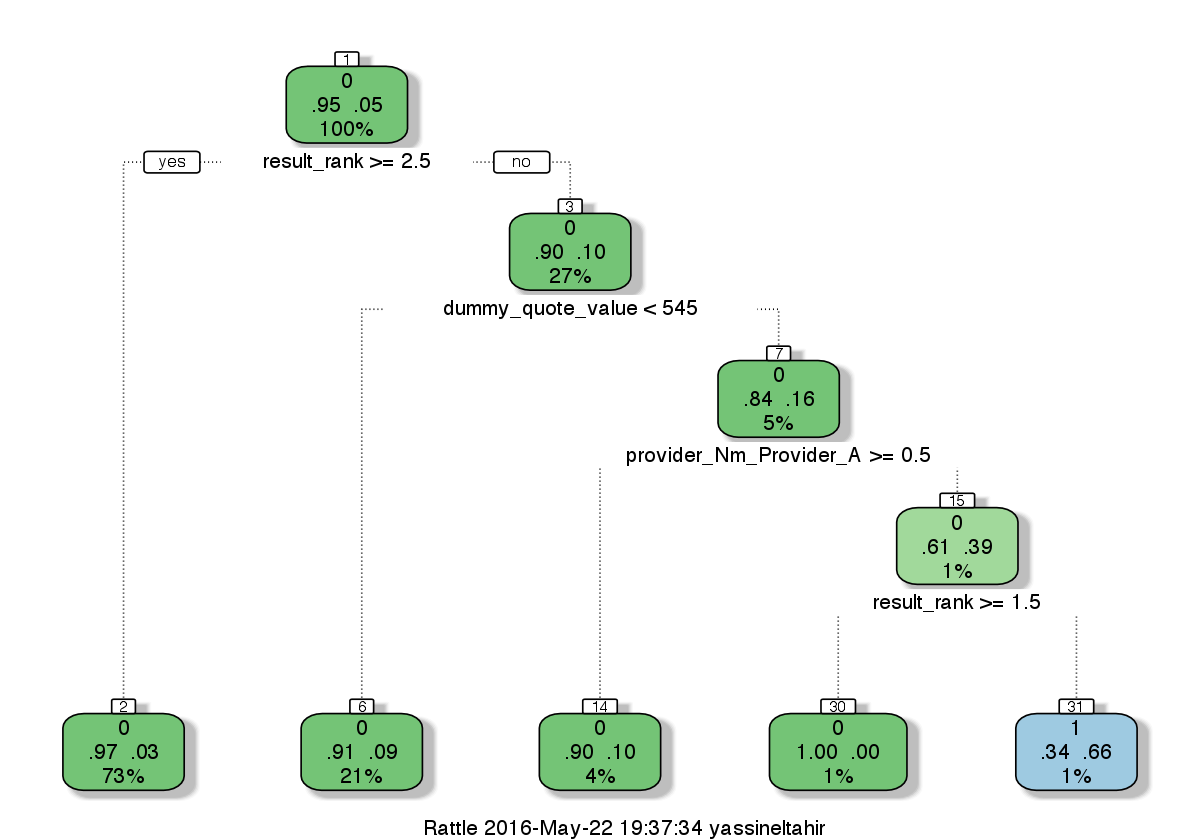

In [62]:
rpart.sale_made <- rpart(Sale_made ~ result_rank + dummy_quote_value + 
                             provider_Nm_Provider_A + provider_Nm_Provider_B,
                    data = dt)

fancyRpartPlot(rpart.sale_made)

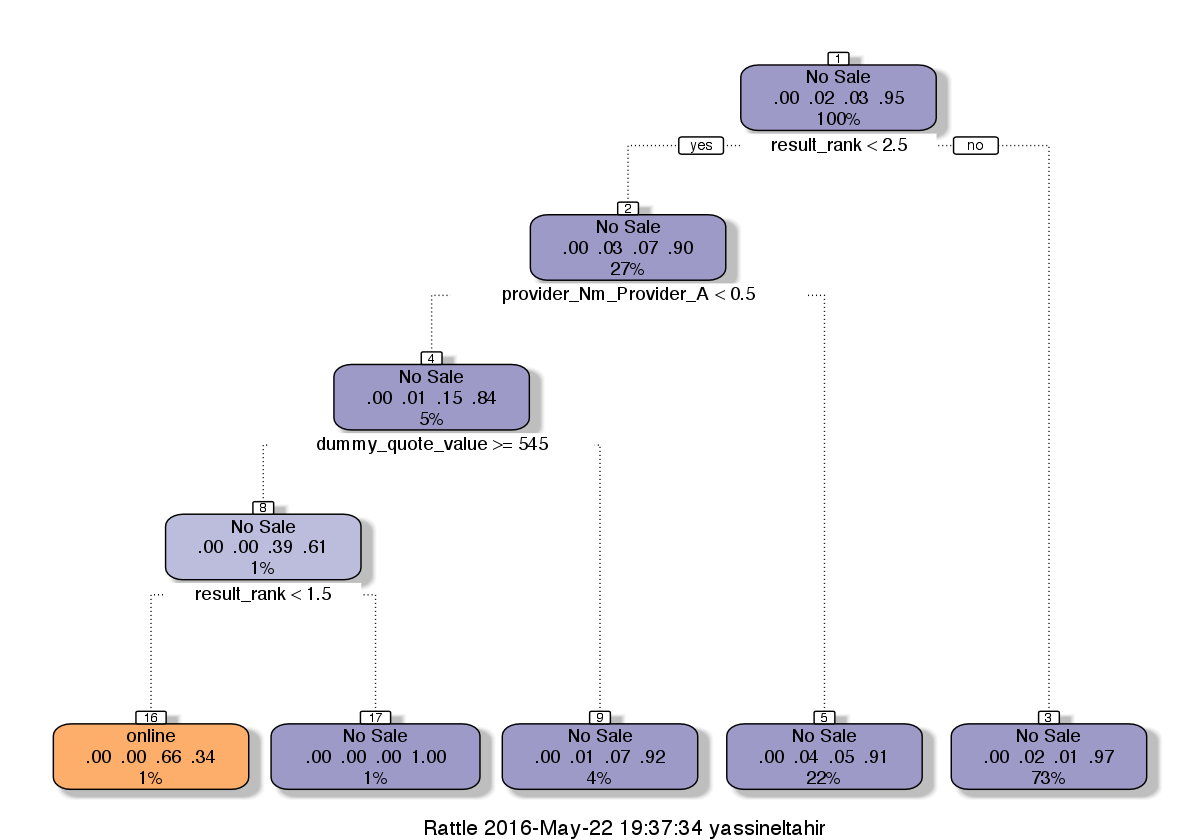

In [63]:
rpart.sale_source <- rpart(Sale_source ~ result_rank + dummy_quote_value + 
                             provider_Nm_Provider_A + provider_Nm_Provider_B,
                           data = dt)

fancyRpartPlot(rpart.sale_source)

pdf 
  2

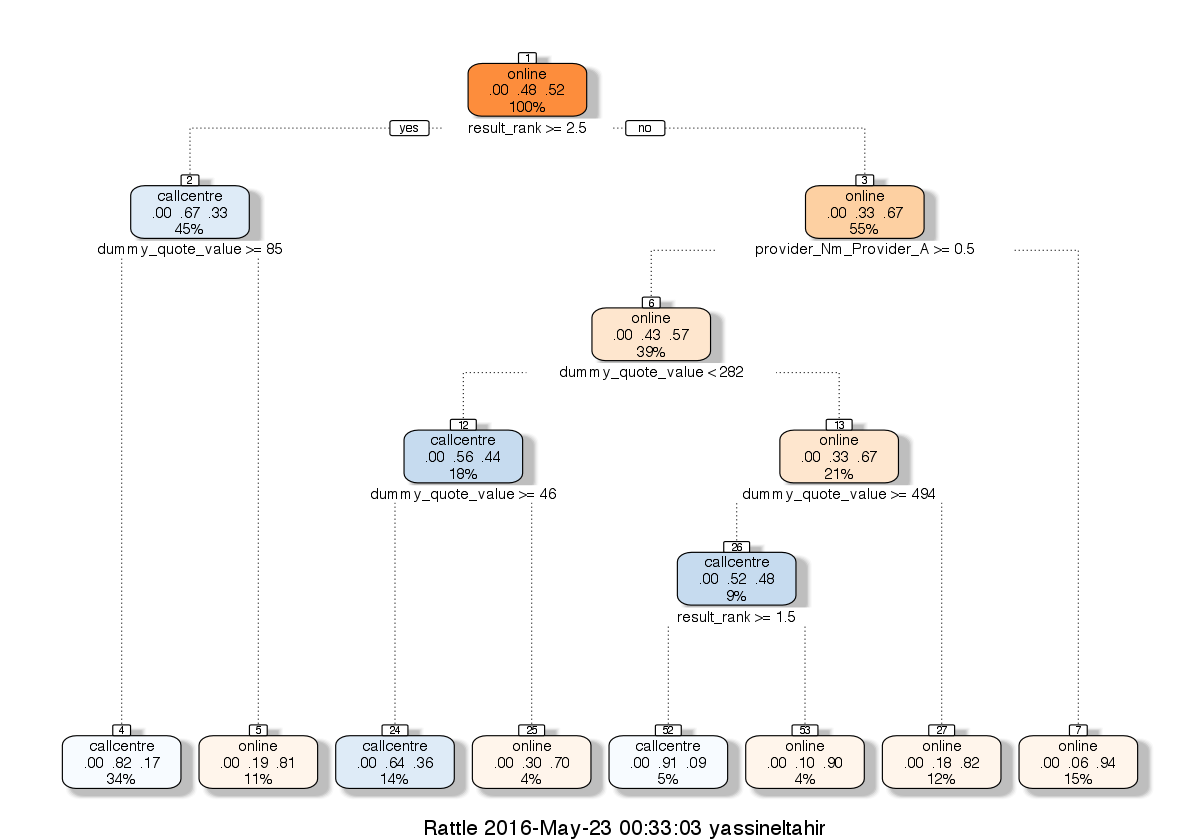

In [113]:
rpart.sale_source.sale <- rpart(Sale_source ~ result_rank + dummy_quote_value + 
                                     provider_Nm_Provider_A + provider_Nm_Provider_B,
                                data = dt[Sale_made=='1'])

fancyRpartPlot(rpart.sale_source.sale)

# jpeg(filename='/Users/yassineltahir/tree_sale_source.jpeg', width=600, height=400, units='px')
# fancyRpartPlot(rpart.sale_source.sale)
# dev.off()

pdf 
  2

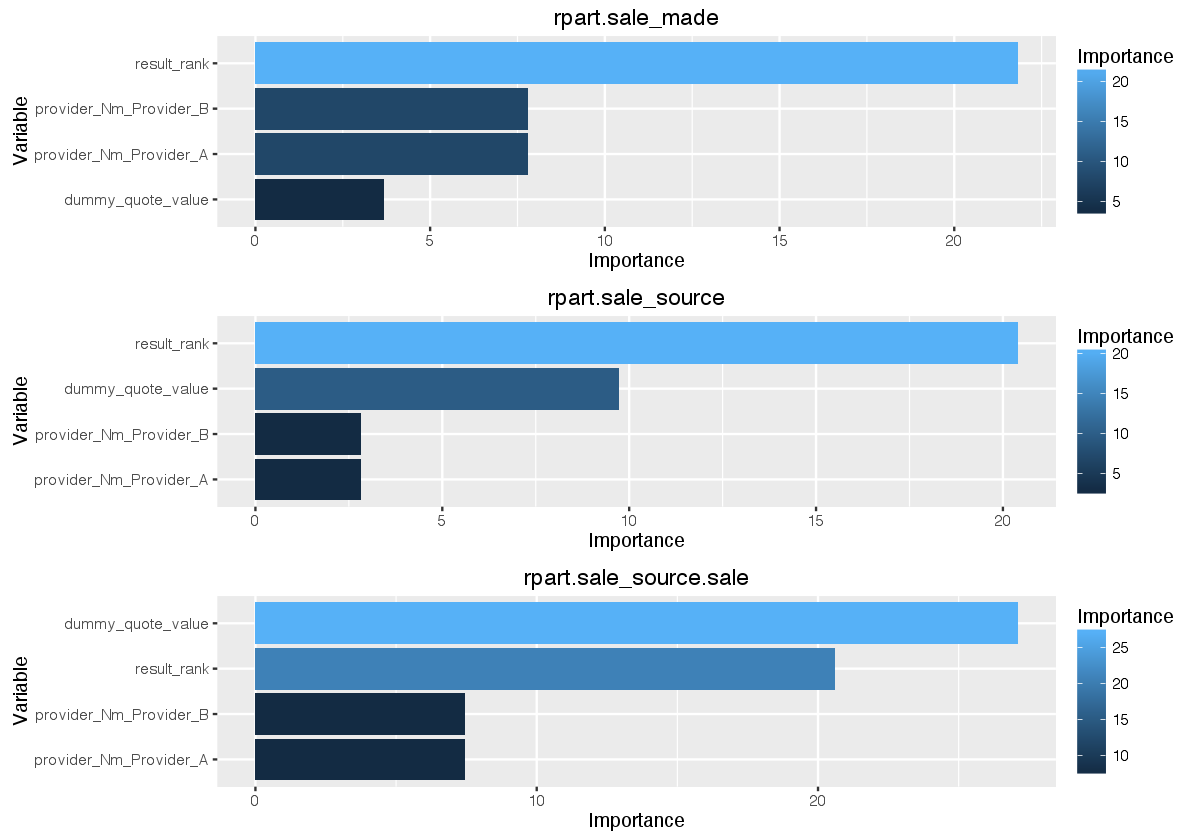

In [110]:
# Variable Importance Plots
models <- c('rpart.sale_made','rpart.sale_source','rpart.sale_source.sale')

# Extract variable importances
var_imp <- lapply(models, function(x){
    
    tmp <- data.frame(get(x)$variable.importance)
    data.table(variable = row.names(tmp), importance = tmp)
    
})

# Plot variable importances
plots <- lapply(1:length(var_imp), function(i){
    
    var_imp_ordered <- transform(var_imp[[i]], variable = reorder(variable, importance.get.x..variable.importance))
    setnames(var_imp_ordered, c('Variable','Importance'))
    
    p <- ggplot(var_imp_ordered, aes(x=as.factor(Variable), y=Importance, fill=Importance)) + 
                geom_bar(stat='identity') +
                coord_flip() +
                labs(title=models[i],
                     x = 'Variable',
                     y = 'Importance')   
})

do.call(grid.arrange,c(plots, ncol=1))

# jpeg(filename='/Users/yassineltahir/result_rank_comparison.jpeg')
# do.call(grid.arrange,c(plots, ncol=1))
# dev.off()

- In terms of predicting a sale, result_rank is comfortably the most important variable. This is inline with the GLM results and what has been seen in the exploratory plots.
- For the situations when a sale was made, the quote price becomes more important.
- Might indicate that customers are driven first by what they think best suits their needs but once they've identified the "ideal" product then price becomes important